## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Ravdess Dataset

https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

Here is the filename identifiers as per the official RAVDESS website:
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)


## Data Preparation

In [2]:
#from google.colab import drive
from google.colab import files

#drive.mount('/content/gdrive')
files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davidefemia","key":"e788164731b6fb1d6b4204938eed1752"}'}

In [3]:
!ls -lha kaggle.json
!pip install -q kaggle # Install kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir Ravdess
!mkdir CremaD
%cd Ravdess
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip
#%cd ../CremaD
#!kaggle datasets download -d ejlok1/cremad
%cd ..

-rw-r--r-- 1 root root 67 Feb 18 11:33 kaggle.json
/content/Ravdess
100% 429M/429M [00:04<00:00, 186MB/s]
100% 429M/429M [00:04<00:00, 106MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01

In [4]:
# Paths for data.
Ravdess = "./Ravdess/audio_speech_actors_01-24/"
#Crema = "/kaggle/input/cremad/AudioWAV/"
#Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
#Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        # fifth part in each file represents the text associated to that file.
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# dataframe for text of files
statement_df = pd.DataFrame(file_statement, columns=['Statement'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, statement_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotion.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
# changing integers to actual statements.
Ravdess_df.Statement.replace({1:"Kids are talking by the door", 2:"Dogs are sitting by the door"}, inplace=True)
Ravdess_df.head()

Emotion                     Statement  \
0   happy  Dogs are sitting by the door   
1   happy  Kids are talking by the door   
2    calm  Kids are talking by the door   
3    calm  Dogs are sitting by the door   
4   happy  Kids are talking by the door   

                                                Path  
0  ./Ravdess/audio_speech_actors_01-24/Actor_12/0...  
1  ./Ravdess/audio_speech_actors_01-24/Actor_12/0...  
2  ./Ravdess/audio_speech_actors_01-24/Actor_12/0...  
3  ./Ravdess/audio_speech_actors_01-24/Actor_12/0...  
4  ./Ravdess/audio_speech_actors_01-24/Actor_12/0...

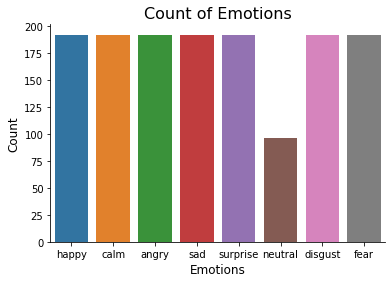

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=Ravdess_df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

<class 'numpy.ndarray'>


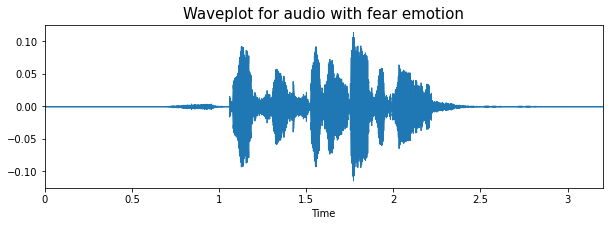

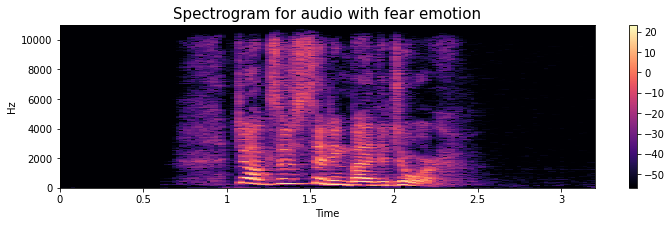

In [12]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
print(type(data))
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

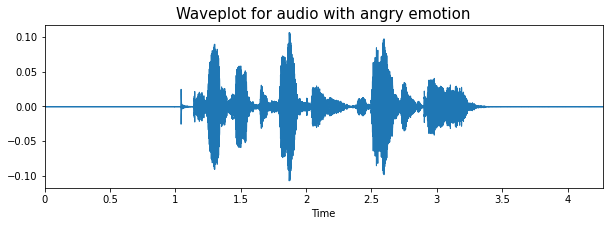

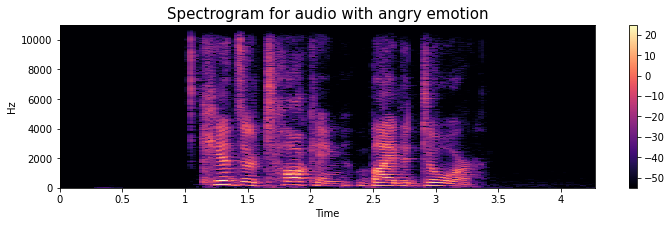

In [15]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

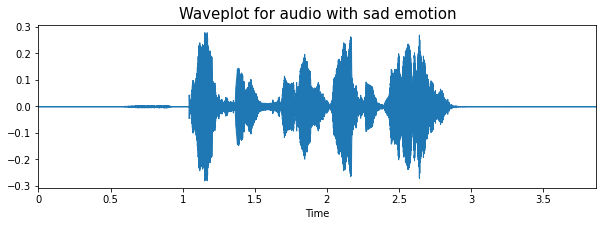

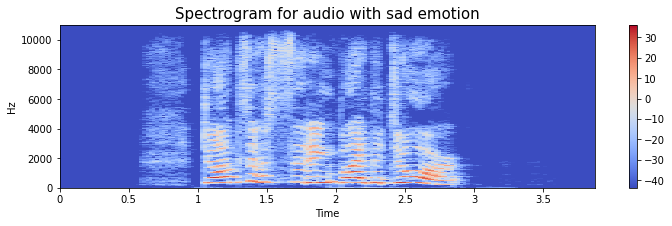

In [16]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

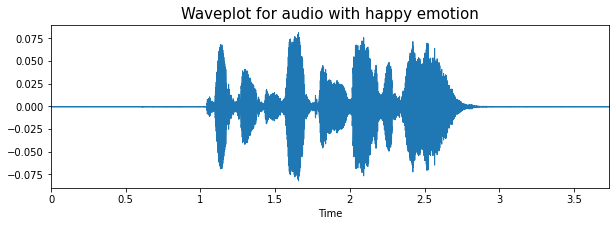

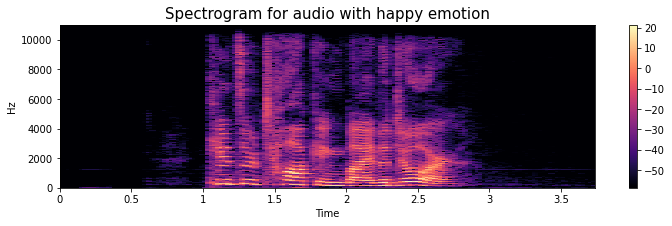

In [18]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation
- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

### Simple Audio

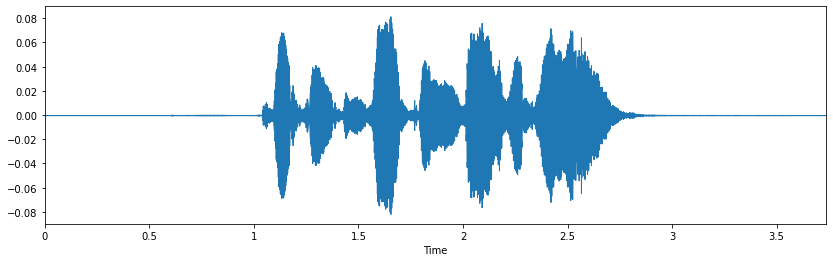

In [21]:
# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### Noise Injection

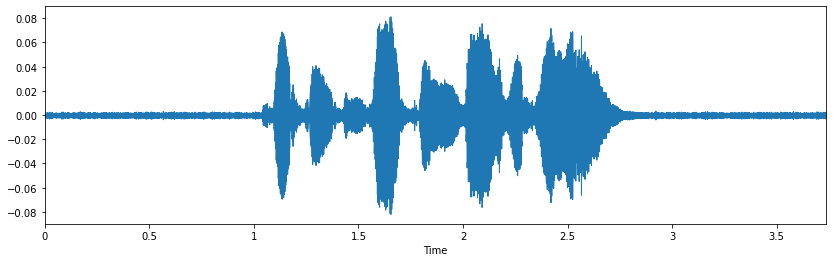

In [22]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Stretching

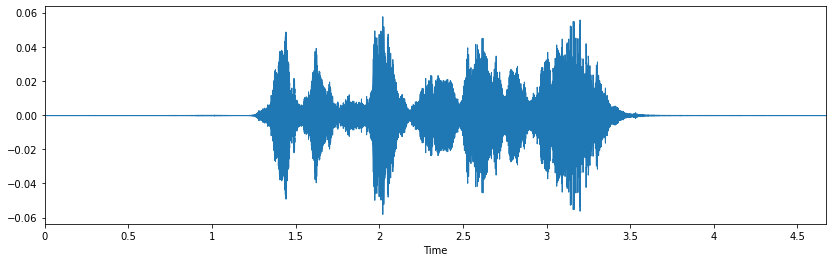

In [23]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

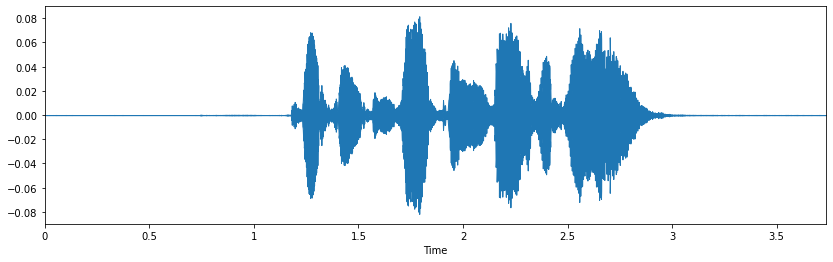

In [24]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitch

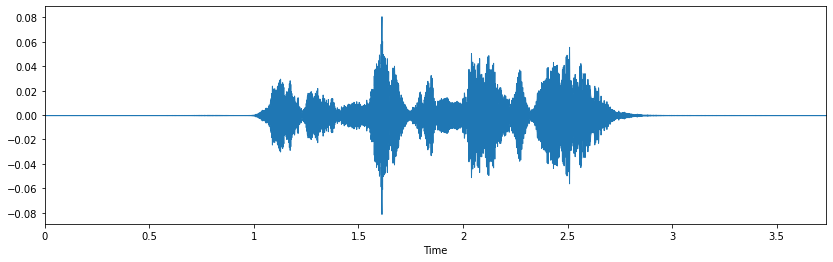

In [25]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![picture](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.

In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [31]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [33]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [34]:
len(X), len(Y), Ravdess_df.Path.shape

(4320, 4320, (1440,))

In [35]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.191980  0.547003  0.585371  0.690379  0.641006  0.546035  0.571217   
1  0.307870  0.651211  0.734334  0.738571  0.706066  0.697149  0.663814   
2  0.182444  0.539076  0.575154  0.722944  0.631315  0.526646  0.582873   
3  0.139630  0.511474  0.532714  0.587445  0.632437  0.577476  0.606816   
4  0.251885  0.609305  0.645295  0.686579  0.738358  0.702441  0.677477   

          7         8         9  ...       153       154       155       156  \
0  0.581414  0.538797  0.578448  ...  0.000554  0.000944  0.000861  0.000621   
1  0.586920  0.607273  0.679828  ...  0.000712  0.001119  0.001001  0.000787   
2  0.566079  0.534756  0.565622  ...  0.000063  0.000069  0.000157  0.000221   
3  0.641477  0.617999  0.525924  ...  0.000037  0.000063  0.000137  0.000065   
4  0.658723  0.645434  0.581937  ...  0.000304  0.000343  0.000413  0.000348   

        157       158       159       160           161  labels  
0  0.000625  0.000467  0.000152  0.000010  1.076957e-07   happy  
1  0.000788  0.000645  0.000320  0.000185  1.780387e-04   happy  
2  0.000199  0.000075  0.000025  0.000002  1.970275e-08   happy  
3  0.000049  0.000022  0.000012  0.000001  2.365954e-08   happy  
4  0.000330  0.000294  0.000275  0.000264  2.600394e-04   happy  

[5 rows x 163 columns]

In [36]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [37]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [38]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [39]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [40]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 29s 523ms/step - loss: 2.0063 - accuracy: 0.2059 - val_loss: 1.9312 - val_accuracy: 0.2926 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 27s 522ms/step - loss: 1.9241 - accuracy: 0.2417 - val_loss: 1.8789 - val_accuracy: 0.2676 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 25s 494ms/step - loss: 1.8443 - accuracy: 0.2753 - val_loss: 1.7836 - val_accuracy: 0.3046 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 26s 511ms/step - loss: 1.8049 - accuracy: 0.2889 - val_loss: 1.7240 - val_accuracy: 0.3343 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 25s 493ms/step - loss: 1.7248 - accuracy: 0.3380 - val_loss: 1.6748 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 26s 510ms/step - loss: 1.6941 - accuracy: 0.3395 - val_loss: 1.6403 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 25s 484ms/st